In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from IPython import display

In [2]:
display.set_matplotlib_formats("svg")
sns.set()
plt.rcParams["font.sans-serif"] = "Liberation Sans"

In [3]:
data = pd.read_csv("dataset/sh300.csv")

In [4]:
data

,datetime,code,open,close,high,low,vol,amount,p_change
0,2021-10-13,300,4880.14,4940.11,4953.38,4869.83,1311428.0,2.800447e+11,1.15
1,2021-10-12,300,4920.66,4883.84,4925.49,4840.77,1680793.0,2.994243e+11,-1.06
2,2021-10-11,300,4941.29,4936.19,4983.73,4930.71,1635116.0,3.151863e+11,0.13
3,2021-10-08,300,4915.73,4929.94,4937.09,4891.63,1689680.0,3.436358e+11,1.31
4,2021-09-30,300,4843.95,4866.38,4876.07,4843.95,1461138.0,2.832547e+11,0.67
...,...,...,...,...,...,...,...,...,...
2854,2010-01-11,300,3593.11,3482.05,3594.53,3465.32,899801.0,1.341140e+11,0.06
2855,2010-01-08,300,3456.91,3480.13,3482.08,3426.70,607902.0,9.019096e+10,0.25
2856,2010-01-07,300,3543.16,3471.46,3558.56,3452.77,803500.0,1.204362e+11,-1.98
2857,2010-01-06,300,3558.70,3541.73,3588.83,3541.17,784731.0,1.210460e+11,-0.63


In [5]:
dataset = np.array(data["high"].tolist())

In [6]:
dataset

array([4953.38, 4925.49, 4983.73, ..., 3558.56, 3588.83, 3577.53])

In [7]:
np.flip(dataset)

array([3577.53, 3588.83, 3558.56, ..., 4983.73, 4925.49, 4953.38])

Text(0.5, 1.0, 'High Trend')

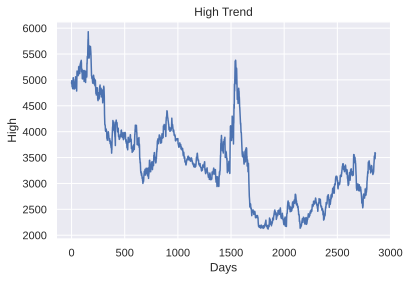

In [8]:
ax = sns.lineplot(x=np.arange(len(dataset)), y=dataset)
ax.set_xlabel("Days")
ax.set_ylabel("High")
ax.set_title("High Trend")

In [9]:
dataset.shape

(2859,)

In [10]:
def generate_dataset(dataset, interval=30):
    
    trainset = []
    testset = []
    train_label = []
    test_label = []
    for i in range(len(dataset) - 300):
        trainset.append(dataset[i:i + interval])
        train_label.append(dataset[i + interval])
    for i in range(len(dataset) - 300, len(dataset) - interval):
        testset.append(dataset[i:i + interval])
        test_label.append(dataset[i + interval])
    return np.array(trainset), np.array(train_label), \
                np.array(testset), np.array(test_label)

In [11]:
trainset, train_label, test, test_label = generate_dataset(dataset)

In [12]:
train_label

array([4843.82, 4835.15, 4893.47, ..., 3182.19, 3269.05, 3258.28])

In [13]:
trainset

array([[4953.38, 4925.49, 4983.73, ..., 4892.2 , 4899.77, 4906.2 ],
       [4925.49, 4983.73, 4937.09, ..., 4899.77, 4906.2 , 4843.82],
       [4983.73, 4937.09, 4876.07, ..., 4906.2 , 4843.82, 4835.15],
       ...,
       [3353.89, 3330.8 , 3315.3 , ..., 3241.6 , 3213.79, 3195.69],
       [3330.8 , 3315.3 , 3272.77, ..., 3213.79, 3195.69, 3182.19],
       [3315.3 , 3272.77, 3264.96, ..., 3195.69, 3182.19, 3269.05]])

In [14]:
class MyDataset(nn.Module):
    
    def __init__(self, trainset, train_label):
        super().__init__()
        
        self.trainset = trainset
        self.train_label = train_label
        
    def __getitem__(self, idx):
        
        return self.trainset[idx], self.train_label[idx]
        
    def __len__(self):
        return len(self.trainset)

In [15]:
class Predictor(nn.Module):
    
    def __init__(self, input_size, hidden_size, norm_size, num_layers=1):
        super().__init__()
        self.batch_norm = nn.BatchNorm1d(norm_size)
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers=num_layers, 
                           batch_first=True)
        self.model = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.batch_norm(x)
        x = x.unsqueeze(dim=-1)
        h = torch.zeros(self.num_layers, batch_size, self.hidden_size).float().to("cuda")
        c = torch.zeros(self.num_layers, batch_size, self.hidden_size).float().to("cuda")
        x, (h, c) = self.rnn(x, (h, c))
        x = self.model(x[:, -1, :])
        return x

In [16]:
BATCH_SIZE = 16
Epoch = 200
criterion = nn.MSELoss()
predictor = Predictor(1, 100, 30)
predictor = predictor.to("cuda")
optimizer = optim.Adam(predictor.parameters(), lr=5e-3)

In [17]:
dataset = MyDataset(trainset=trainset, train_label=train_label)

In [18]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, 
                       drop_last=False, num_workers=4)
losses = []

In [19]:
predictor = predictor.train()
for epoch in range(1, Epoch + 1):
    temp_loss = []
    for idx, (d, l) in enumerate(dataloader):
        d = d.float().to("cuda")
        l = l.float().to("cuda")
        
        out = predictor(d)
        loss = criterion(out.squeeze(1), l)
        predictor.zero_grad()
        loss.backward()
        optimizer.step()
        
        temp_loss.append(loss.item())
        print("Epoch = {:<3} Step[{:3}/{}] Loss = {:10}".format(epoch, 
                                idx + 1, len(dataloader), loss.item()))
    losses.append(np.mean(temp_loss))
    if epoch > 2:
        ax = sns.lineplot(x=np.arange(len(losses[-50:])) + 1, y=losses[-50:], 
                          label="Predictor")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_title("Traing Process")
        ax.legend()
        plt.pause(0.001)
    if epoch % 20 == 0:
        display.clear_output()

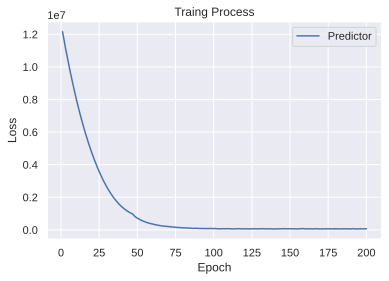

In [20]:
ax = sns.lineplot(x=np.arange(len(losses)) + 1, y=losses, 
                              label="Predictor")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Traing Process")
ax.legend()
plt.savefig("task2 loss.svg", format="svg")
plt.pause(0.001)

In [21]:
test = torch.from_numpy(test).float().to("cuda")

In [22]:
predictor = predictor.eval()

with torch.no_grad():
    
    test_out = predictor(test)[:, -1]

In [23]:
test_out = test_out.cpu().data.numpy()

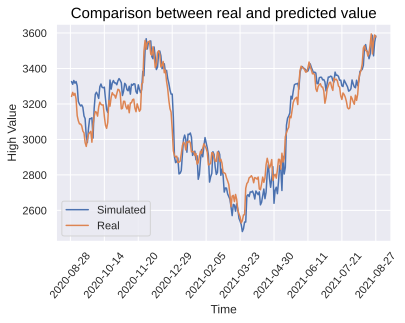

In [39]:
ax = sns.lineplot(x=np.arange(len(test_out)) + 1, y=test_out, label="Simulated")
ax.plot(np.arange(len(test_label)) + 1, test_label, label="Real")
ax.set_xlabel("Time")
ax.set_ylabel("High Value")
ax.set_title("Comparison between real and predicted value",
            fontdict={"color": "black", "fontsize": 15})
ax.set_xticks(np.linspace(0, len(test_out), 10))
ax.set_xticklabels(data["datetime"][:270][::-27], rotation=50)
ax.legend()
plt.savefig("predict.svg", format="svg", bbox_inches='tight')
plt.pause(0.001)